In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
from helicopter_environment import HelicopterTrain

In [3]:
from training_utils import OUActionNoise, Buffer, update_target, get_actor, get_critic, policy

## DDPG-trained $\theta_c$, PID-controlled $\theta_0$

In [4]:
env = HelicopterTrain(mode='theta_0_PID', max_time=45, dt=0.01)

num_states = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]

upper_bound, lower_bound = env.action_space.high, env.action_space.low

print(num_states, num_actions, upper_bound, lower_bound)

7 1 [1.57079633] [-1.57079633]


In [5]:
std_dev = np.pi/16
ou_noise = OUActionNoise(mean=np.zeros(num_actions), std_deviation=float(std_dev) * np.ones(num_actions))

In [6]:
filepath = 'actor1/actor_2022-08-25_211715'

actor_model = tf.keras.models.load_model(filepath)

69614.30147250835


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


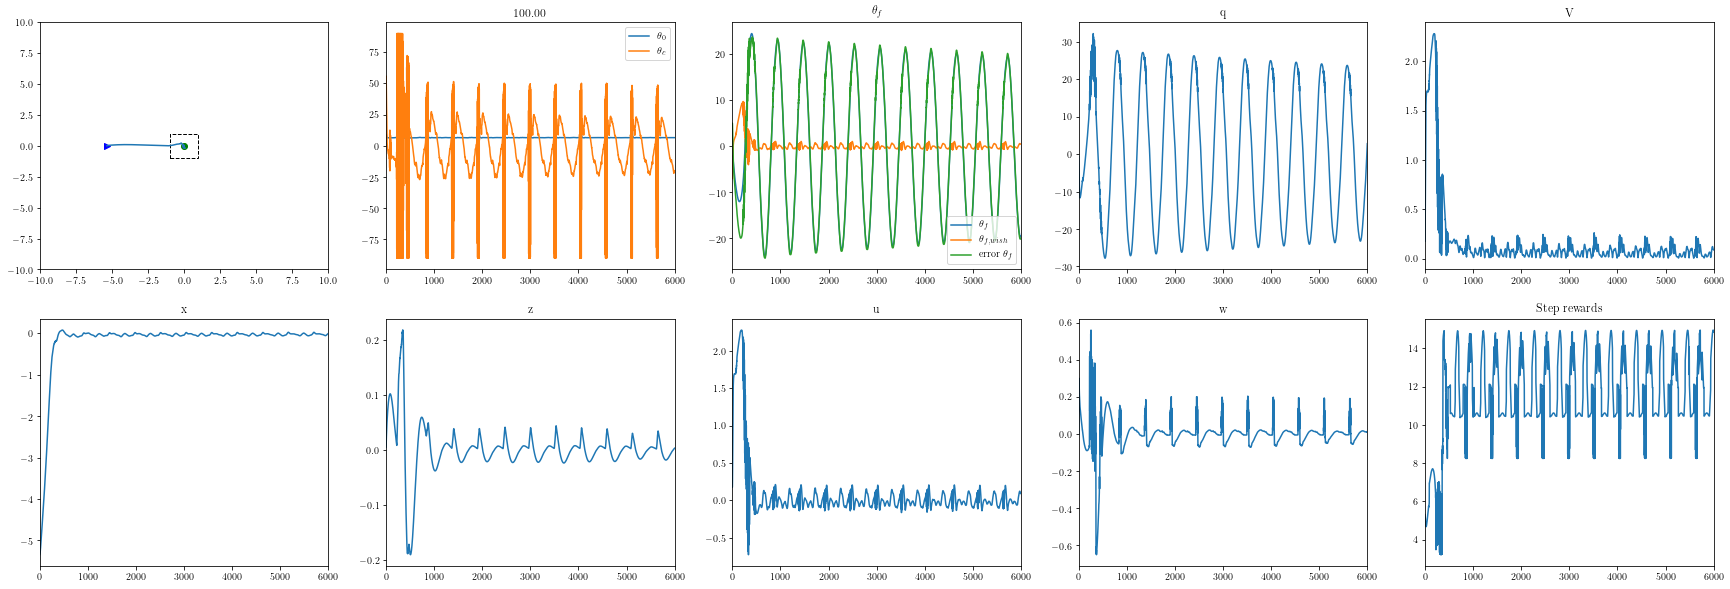

In [25]:
env_long = HelicopterTrain(max_time=60, mode='theta_0_PID')

prev_state = env_long.reset()
first_state = prev_state
episodic_reward = 0

ou_noise.reset()

while True:

    tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

    action = policy(tf_prev_state, actor_model, ou_noise, add_noise=False)
    state, reward, done, info = env_long.step(action)
    
    episodic_reward += reward
    if done:
        break

    prev_state = state

print(episodic_reward)
env_long.plot_trajectory()

In [26]:
from matplotlib.ticker import AutoMinorLocator
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
})

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


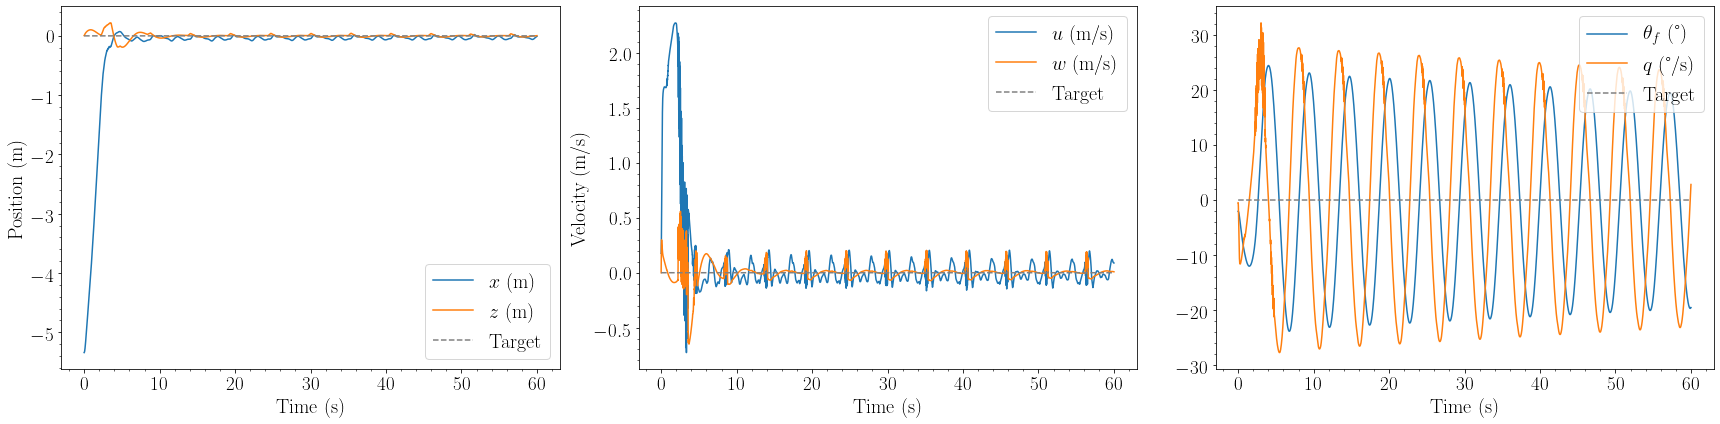

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6))

time = np.arange(len(env_long.history[:, 0]))*env_long.dt

axs[0].plot(time, env_long.history[:, 0], label=r'$x$ (m)')
axs[0].plot(time, env_long.history[:, 2], label=r'$z$ (m)')
axs[0].set_ylabel('Position (m)', fontsize=20)

axs[1].plot(time, env_long.history[:, 1], label=r'$u$ (m/s)')
axs[1].plot(time, env_long.history[:, 3], label=r'$w$ (m/s)')
axs[1].set_ylabel('Velocity (m/s)', fontsize=20)

axs[2].plot(time, np.degrees(env_long.history[:, 4]), label=r'$\theta_f$ (°)')
axs[2].plot(time, np.degrees(env_long.history[:, 5]), label=r'$q$ (°/s)')

for ax in axs:
    ax.plot(time, np.zeros_like(time), label=r'Target', linestyle='dashed', color='grey')
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis='x', labelsize=19)
    ax.tick_params(axis='y', labelsize=19)
    ax.legend(fontsize=20)
    ax.set_xlabel(r'Time (s)', fontsize=20)

plt.tight_layout()
plt.savefig('trained_cyclic_only.pdf')

## Full PID control

85356.25603988105


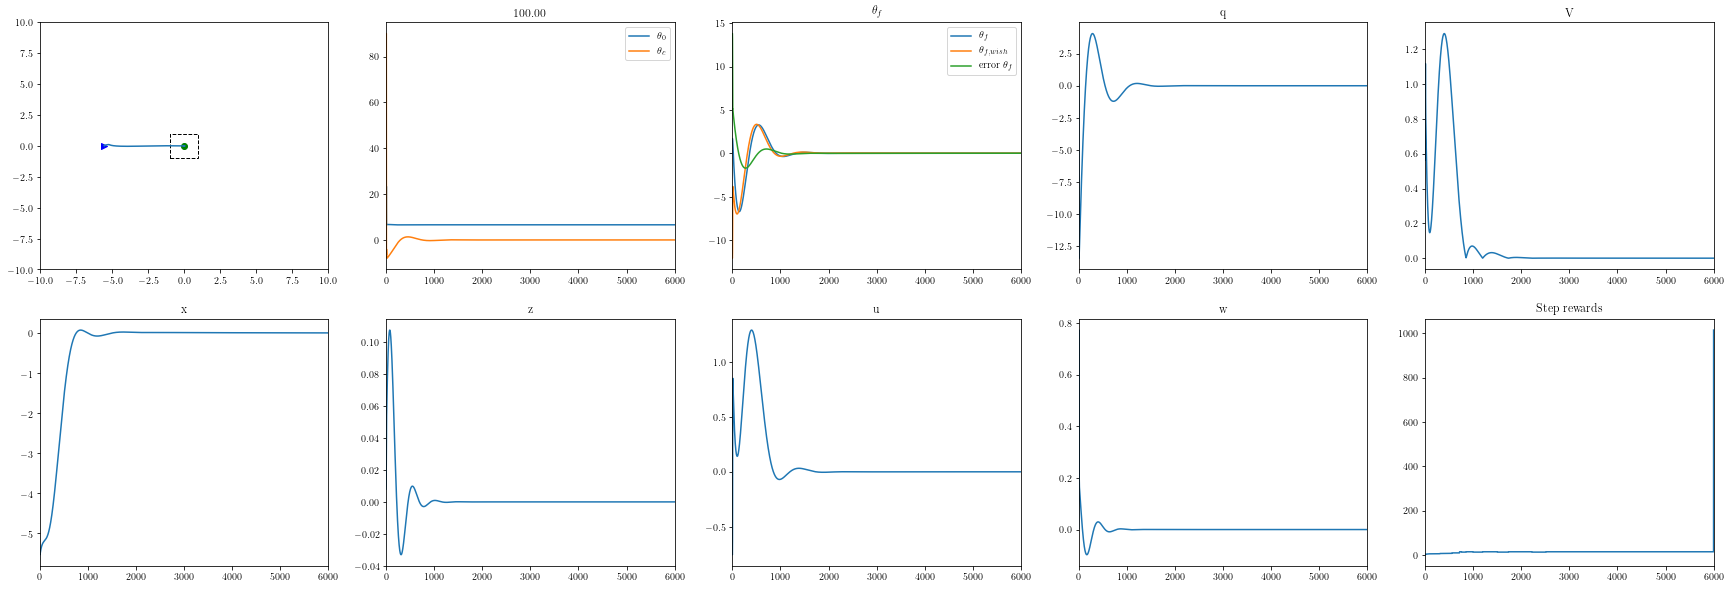

In [32]:
env_PID = HelicopterTrain(max_time=60, mode='full_PID')

prev_state = first_state
episodic_reward = 0

ou_noise.reset()

while True:

    tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
    state, reward, done, info = env_PID.step(1)
    
    episodic_reward += reward

    if done:
        break

    prev_state = state

print(episodic_reward)
env_PID.plot_trajectory()

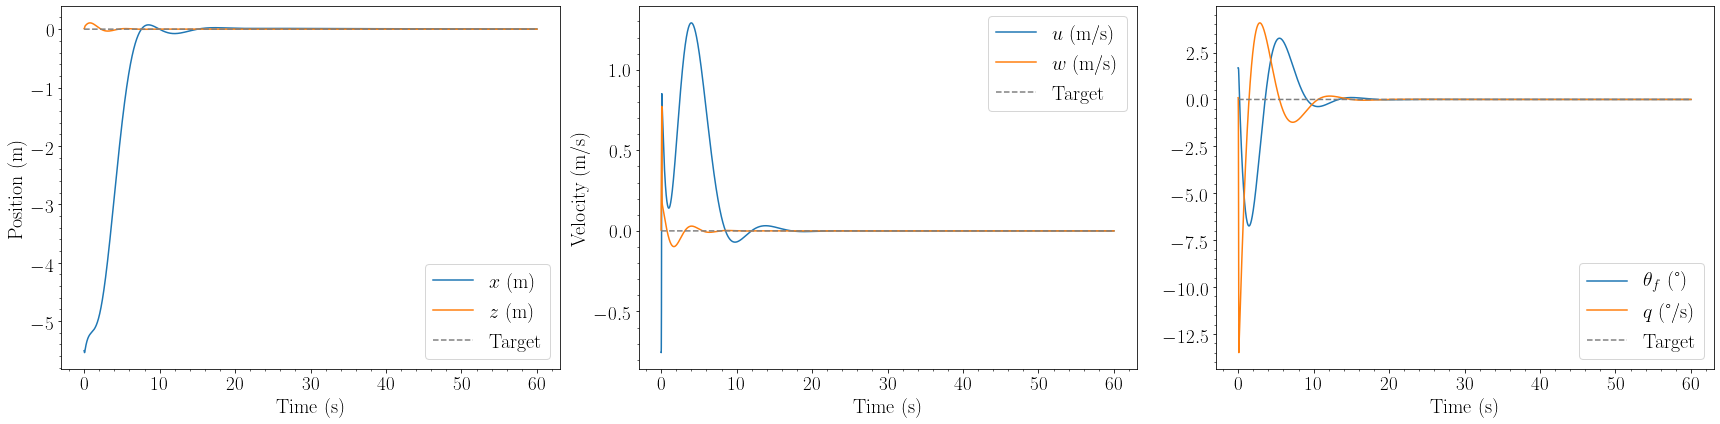

In [33]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6))

time = np.arange(len(env_PID.history[:, 0]))*env_PID.dt

axs[0].plot(time, env_PID.history[:, 0], label=r'$x$ (m)')
axs[0].plot(time, env_PID.history[:, 2], label=r'$z$ (m)')
axs[0].set_ylabel('Position (m)', fontsize=20)

axs[1].plot(time, env_PID.history[:, 1], label=r'$u$ (m/s)')
axs[1].plot(time, env_PID.history[:, 3], label=r'$w$ (m/s)')
axs[1].set_ylabel('Velocity (m/s)', fontsize=20)

axs[2].plot(time, np.degrees(env_PID.history[:, 4]), label=r'$\theta_f$ (°)')
axs[2].plot(time, np.degrees(env_PID.history[:, 5]), label=r'$q$ (°/s)')

for ax in axs:
    ax.plot(time, np.zeros_like(time), label=r'Target', linestyle='dashed', color='grey')
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis='x', labelsize=19)
    ax.tick_params(axis='y', labelsize=19)
    ax.legend(fontsize=20)
    ax.set_xlabel(r'Time (s)', fontsize=20)

plt.tight_layout()
plt.savefig('PID_run.pdf')

In [34]:
actor_untrained = get_actor(num_states, num_actions, upper_bound)

2410.7701944226865


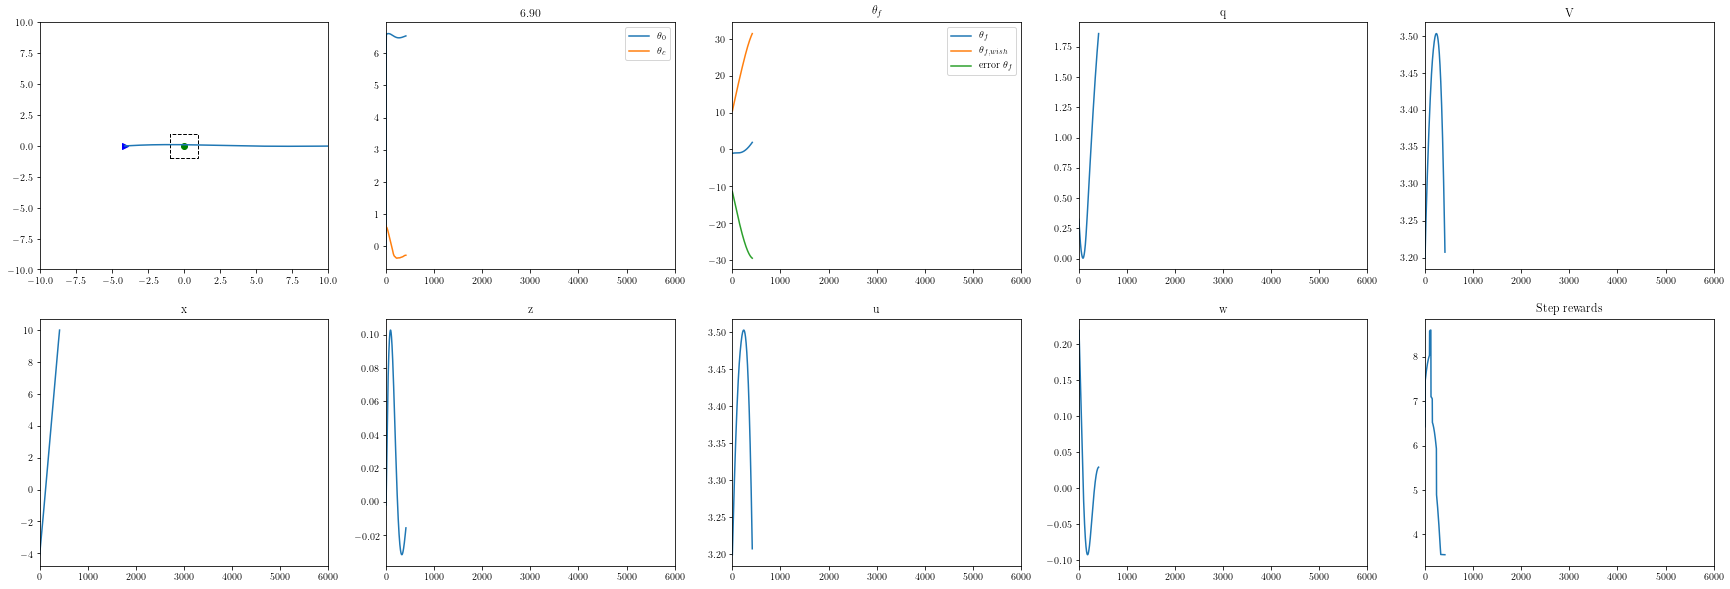

In [36]:
env_untrained = HelicopterTrain(max_time=60, mode='theta_0_PID')

prev_state = first_state
episodic_reward = 0

ou_noise.reset()

while True:

    tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

    action = policy(tf_prev_state, actor_untrained, ou_noise, add_noise=False)
    state, reward, done, info = env_untrained.step(action)
    
    episodic_reward += reward

    if done:
        break

    prev_state = state

print(episodic_reward)
env_untrained.plot_trajectory()

## Fully DDPG-trained agent

In [37]:
filepath = 'mac/full/actor/actor_2022-08-28_232951'

actor_full = tf.keras.models.load_model(filepath)

67102.31964743772


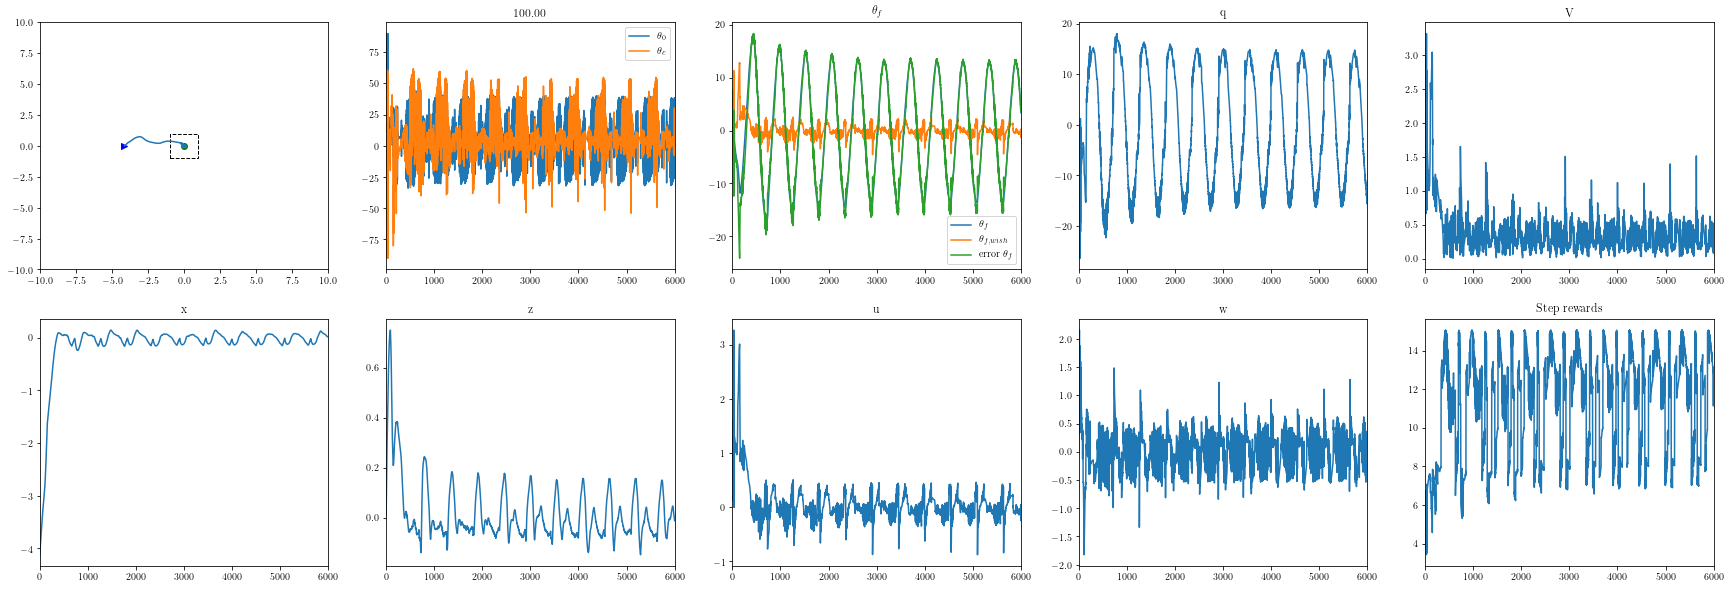

In [38]:
env_full = HelicopterTrain(max_time=60, mode='full')

prev_state = first_state
episodic_reward = 0

ou_noise.reset()

while True:

    tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

    action = policy(tf_prev_state, actor_full, ou_noise, add_noise=False)
    state, reward, done, info = env_full.step(action)
    
    episodic_reward += reward

    if done:
        break

    prev_state = state

print(episodic_reward)
env_full.plot_trajectory()

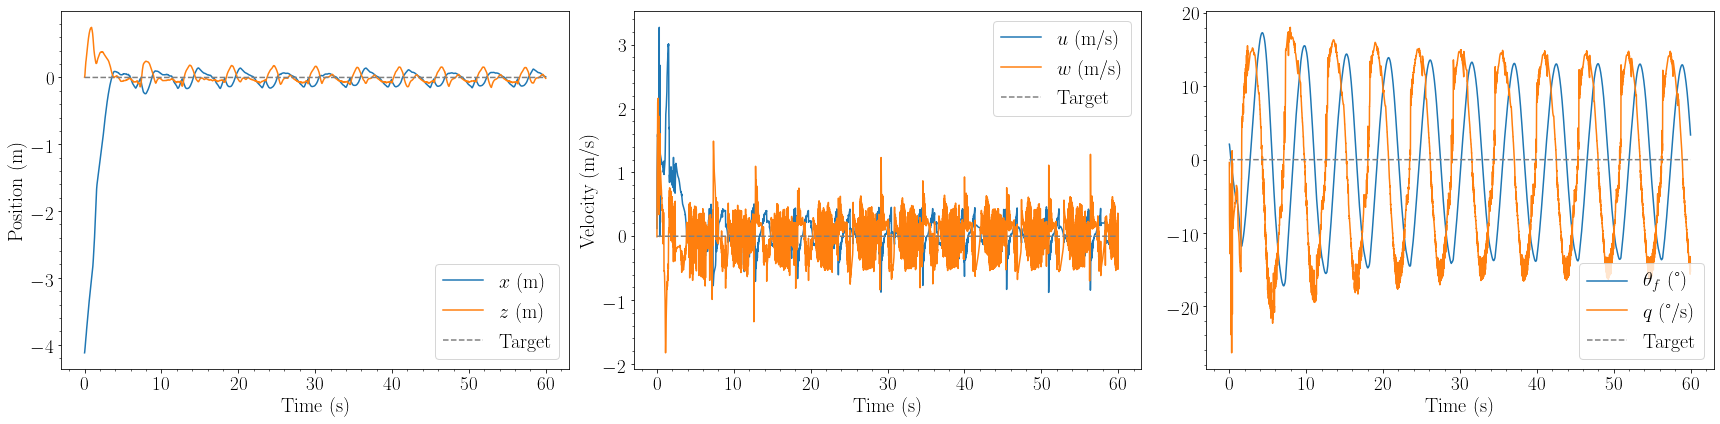

In [39]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6))

time = np.arange(len(env_full.history[:, 0]))*env_full.dt

axs[0].plot(time, env_full.history[:, 0], label=r'$x$ (m)')
axs[0].plot(time, env_full.history[:, 2], label=r'$z$ (m)')
axs[0].set_ylabel('Position (m)', fontsize=20)

axs[1].plot(time, env_full.history[:, 1], label=r'$u$ (m/s)')
axs[1].plot(time, env_full.history[:, 3], label=r'$w$ (m/s)')
axs[1].set_ylabel('Velocity (m/s)', fontsize=20)

axs[2].plot(time, np.degrees(env_full.history[:, 4]), label=r'$\theta_f$ (°)')
axs[2].plot(time, np.degrees(env_full.history[:, 5]), label=r'$q$ (°/s)')

for ax in axs:
    ax.plot(time, np.zeros_like(time), label=r'Target', linestyle='dashed', color='grey')
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis='x', labelsize=19)
    ax.tick_params(axis='y', labelsize=19)
    ax.legend(fontsize=20)
    ax.set_xlabel(r'Time (s)', fontsize=20)

plt.tight_layout()
plt.savefig('trained_full.pdf')

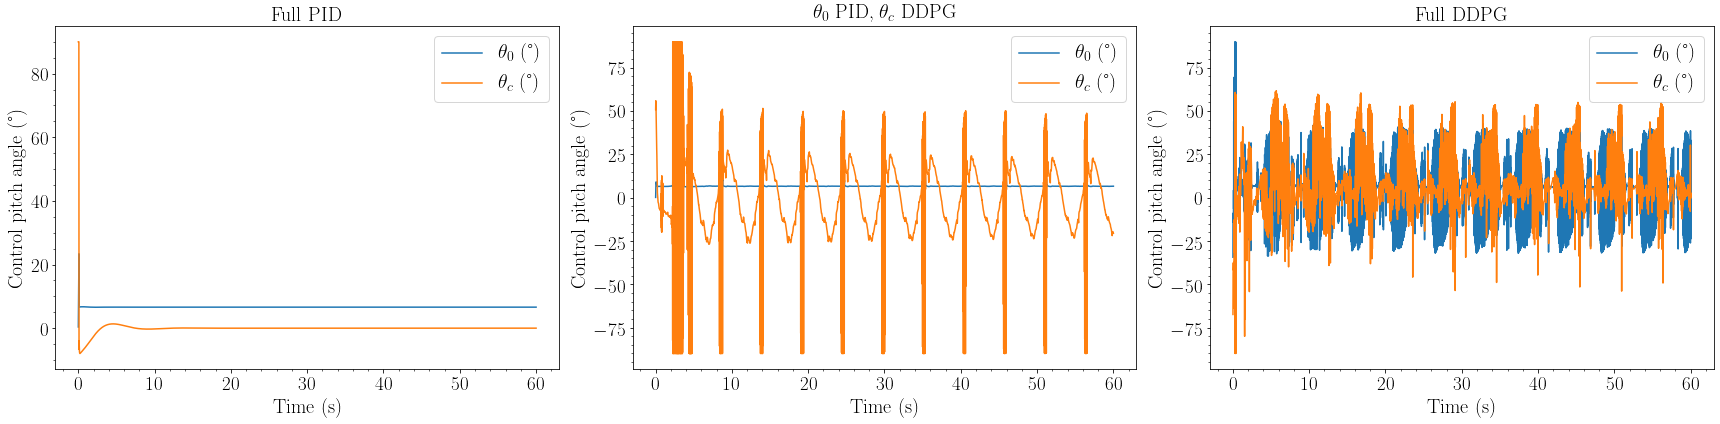

In [50]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6))

def plot_actions(ax, env, title=''):
    time = np.arange(1, len(env_full.history[:, 0]))*env_full.dt
    theta_0 = [a[0] for a in env.action_history]
    theta_c = [a[1] for a in env.action_history]
    
    ax.plot(time, np.degrees(theta_0), label=r'$\theta_0$ (°)')
    ax.plot(time, np.degrees(theta_c), label=r'$\theta_c$ (°)')
    ax.set_title(title, fontsize=20)

for ax, env, title in zip(axs, [env_PID, env_long, env_full], 
                   ['Full PID', r'$\theta_0$ PID, $\theta_c$ DDPG',
                   'Full DDPG']):
    plot_actions(ax, env, title=title)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis='x', labelsize=19)
    ax.tick_params(axis='y', labelsize=19)
    ax.legend(fontsize=20)
    ax.set_xlabel(r'Time (s)', fontsize=20)
    ax.set_ylabel(r'Control pitch angle (°)', fontsize=20)

plt.tight_layout()
plt.savefig('control_comparison.pdf')

In [52]:
avg_rewards = np.genfromtxt('mac/avg_reward_history_2022-08-28_232951.txt')

In [55]:
avg_rewards2 = np.genfromtxt('mac/avg_reward_history_2022-08-27_174935.txt')

In [57]:
avg_rewards3 = np.genfromtxt('mac/avg_reward_history_2022-08-27_001701.txt')

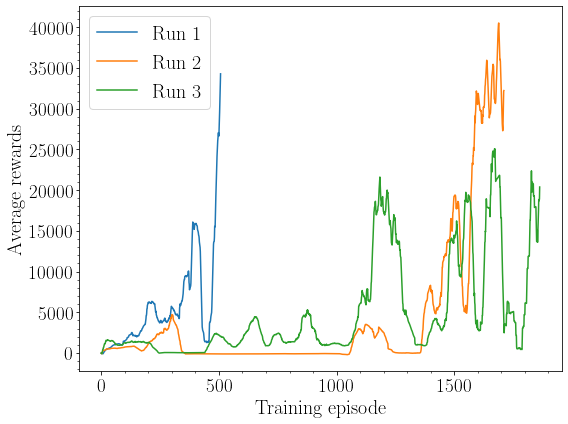

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(avg_rewards, label='Run 1')
ax.plot(avg_rewards2, label='Run 2')
ax.plot(avg_rewards3, label='Run 3')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis='x', labelsize=19)
ax.tick_params(axis='y', labelsize=19)
ax.legend(fontsize=20)
ax.set_xlabel(r'Training episode', fontsize=20)
ax.set_ylabel(r'Average rewards', fontsize=20)

plt.tight_layout()
plt.savefig('training_full.pdf')

In [66]:
names = ['PID', 'Hybrid', 'DDPG']

dict_agents = {n: {'rounds': [], 'rewards': []} for n in names}

for i in range(100):
    print(f'================{i}==================')
    first_state = env_PID.reset()
    for name, env, actor in zip(names, [env_PID, env_long, env_full], [None, actor_model, actor_full]):
        env.reset()
        env.state = first_state
        
        prev_state = env.state
        
        episodic_reward = 0
        
        while True:
            
            if actor is not None:

                tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

                action = policy(tf_prev_state, actor, ou_noise, add_noise=False)
            
            else:
                action = None

            state, reward, done, info = env.step(action)

            episodic_reward += reward

            if done:
                dict_agents[name]['rounds'].append(env.rounds)
                dict_agents[name]['rewards'].append(episodic_reward)
                print(name, env.rounds, episodic_reward)
                break

            prev_state = state

================0==================
PID 0.0 85725.17568826329
Hybrid 0.0 69735.63034529028
DDPG 0.0 63807.051026107016
================1==================
PID 0.0 85684.87493987221
Hybrid 0.0 69465.49977858728
DDPG 0.0 65161.168601674646
================2==================
PID 0.0 86099.71756418022
Hybrid 0.0 70931.32724215662
DDPG 0.0 67872.29089368171
================3==================
PID 0.0 85481.62734934504
Hybrid 0.0 78492.63422037565
DDPG 0.0 68008.02469606008
================4==================
PID 0.0 86847.77741644728
Hybrid 0.0 72910.98378127464
DDPG 0.0 67274.49336256219
================5==================
PID 0.0 86305.61443066607
Hybrid 0.0 79330.88991434113
DDPG 0.0 69905.83514411584
================6==================
PID 0.0 86840.45549041725
Hybrid 0.0 83200.98636251158
DDPG 0.0 70498.18233363364
================7==================
PID 0.0 85233.62664412007
Hybrid 0.0 68382.78402535028
DDPG 0.0 64987.13486049633
================8==================
PID 0.0 85164.1789

In [78]:
for n in names:
    print(f'=============={n}==============')
    print(f"{100-(np.array(dict_agents[n]['rounds']) > 0).sum():.2f}%")
    print(f"{np.mean(dict_agents[n]['rewards']):.2f} +- {np.std(dict_agents[n]['rewards']):.2f}")

==============PID==============
100.00%
85891.39 +- 709.53
==============Hybrid==============
100.00%
74778.15 +- 5043.98
==============DDPG==============
99.00%
67029.97 +- 7392.96
